# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.1 MB/s eta 0:00:00


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [2]:
##Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
from worclipo.load_data import load_data
# from worcliver.load_data import load_data
import pandas as pd
#from ecg.load_data import load_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# feature space splitsen in labels en features
features = pd.DataFrame(data)
ground_truth = data['label']
features.pop('label')
ground_truth = ground_truth.map(lambda x: 1 if x == 'liposarcoma' else 0)
print(sum(ground_truth)) # dus de dataset is balanced
#features met alleen maar missing data verwijderen
# zero_columns = [column for column in features.columns if (features[column] == 0).all()]
constant_columns = [col for col in features.columns if features[col].nunique() == 1]
features = features.drop(columns=constant_columns)
# features = features.drop(columns=zero_columns)
print(f'The number of features (without missing data features): {len(features.columns)}')

#split data
X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=42)
print(f"Aantal samples in training set: {len(X_train)}")
print(f"Aantal samples in test set: {len(X_test)}")

The number of samples: 115
The number of columns: 494
58
The number of features (without missing data features): 474
Aantal samples in training set: 92
Aantal samples in test set: 23


In [3]:
def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    # y_score = y_score[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    # plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt
# num_cols = X_train.select_dtypes(include=['number']).columns  # Alleen numerieke kolommen
# num_features = len(num_cols)  # Aantal numerieke features
# print(num_features)
# # Instellingen voor het plotten van meerdere histogrammen
# plt.figure(figsize=(15, 12))
# for i, col in enumerate(num_cols[:494]):  # Eerst 20 kolommen om het overzichtelijk te houden
#     plt.subplot(50, 10, i + 1)  # 4 rijen, 5 kolommen per plotpagina
#     sns.histplot(data[col], bins=30, kde=True)
#     # plt.title(col)
#     # plt.xlabel("")
#     # plt.ylabel("Frequentie")

# plt.tight_layout()
# plt.show()

# Controleren voor elke feature of data normaal verdeeld is

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


Aantal features normaal verdeeld in beide klassen: 63
Aantal significant verschillende features: 32


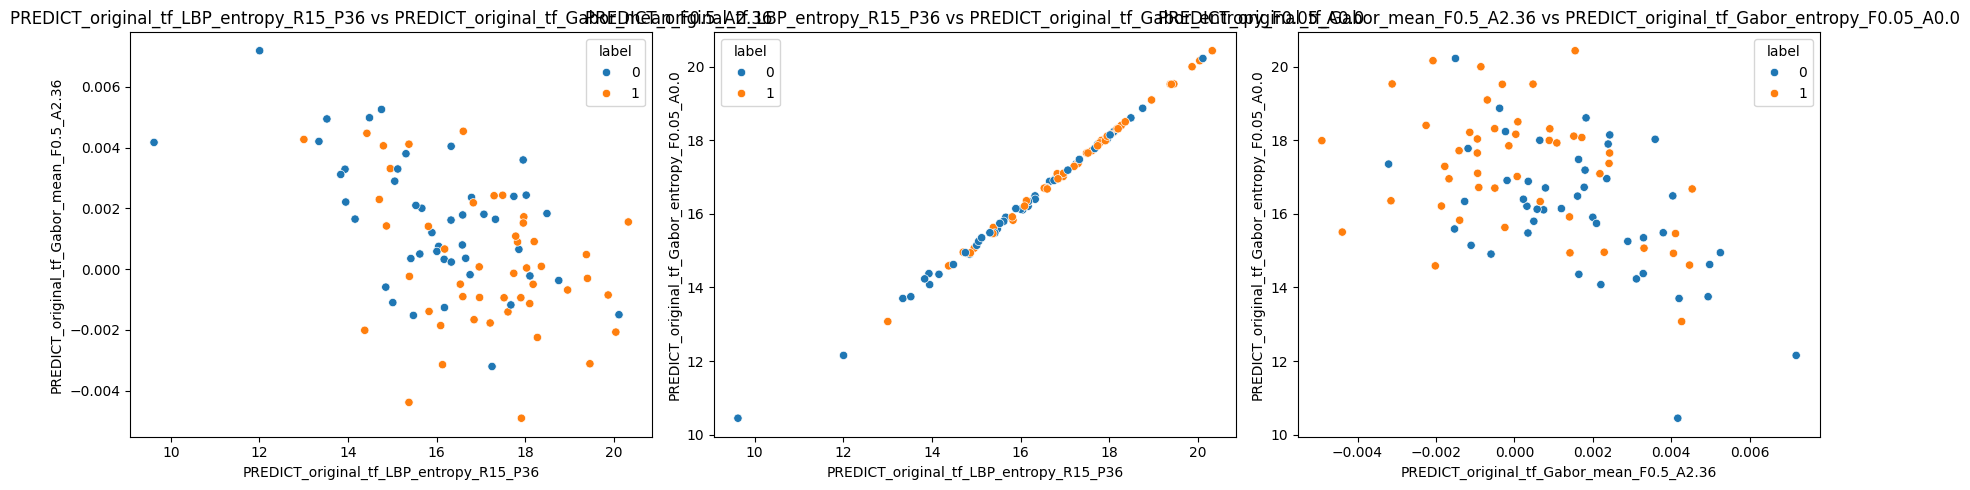

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind

# Shapiro-Wilk test voor normaliteit per feature
normal_features = []
for col in X_train.columns:
    class_0 = X_train[col][y_train == 0]
    class_1 = X_train[col][y_train == 1]

    p_0 = shapiro(class_0)[1]  # p-waarde klasse 0
    p_1 = shapiro(class_1)[1]  # p-waarde klasse 1

    if p_0 > 0.05 and p_1 > 0.05:
        normal_features.append(col)

print(f"Aantal features normaal verdeeld in beide klassen: {len(normal_features)}")

# t-test om significante verschillen te vinden
significant_features = []
alpha = 0.05

for col in normal_features:
    class_0 = X_train[col][y_train == 0]
    class_1 = X_train[col][y_train == 1]

    stat, p = ttest_ind(class_0, class_1, equal_var=False)

    if p < alpha:
        significant_features.append((col, p))

# Sorteer features op p-waarde (laagste eerst)
significant_features.sort(key=lambda x: x[1])

print(f"Aantal significant verschillende features: {len(significant_features)}")


# Minimaal 3 features nodig voor scatterplots
if len(significant_features) >= 3:
    feature_1, feature_2, feature_3 = [f[0] for f in significant_features[:9:3]]

    # Maak scatterplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.scatterplot(x=X_train[feature_1], y=X_train[feature_2], hue=y_train, ax=axes[0])
    axes[0].set_title(f'{feature_1} vs {feature_2}')

    sns.scatterplot(x=X_train[feature_1], y=X_train[feature_3], hue=y_train, ax=axes[1])
    axes[1].set_title(f'{feature_1} vs {feature_3}')

    sns.scatterplot(x=X_train[feature_2], y=X_train[feature_3], hue=y_train, ax=axes[2])
    axes[2].set_title(f'{feature_2} vs {feature_3}')

    plt.tight_layout()
    plt.show()
else:
    print("Niet genoeg significante features om scatterplots te maken.")



# Scalen van feature data

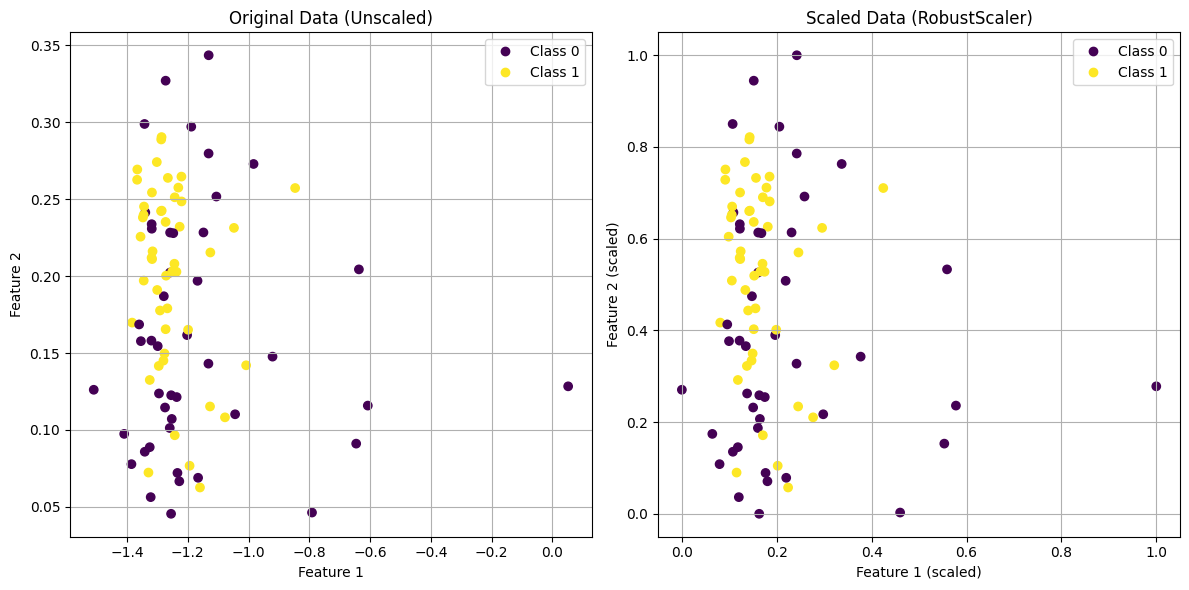

In [5]:
# scaling
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# #scaling plotten op de eerste twee features
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Eerste subplot
scatter = plt.scatter(X_train.iloc[:, 80], X_train.iloc[:, 1], c=y_train, label='Original data') #let op, deze plot is anders doordat je een dataframe hebt
plt.title('Original Data (Unscaled)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True)

plt.subplot(1, 2, 2)  # Tweede subplot
scatter = plt.scatter(X_train_scaled[:, 80], X_train_scaled[:, 1], c=y_train, label='Scaled data') #hier heb je te maken met numpy arrays
plt.title('Scaled Data (RobustScaler)')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0', 'Class 1'])
plt.grid(True)
plt.tight_layout()
plt.show()


# SVM


## Kernel kiezen

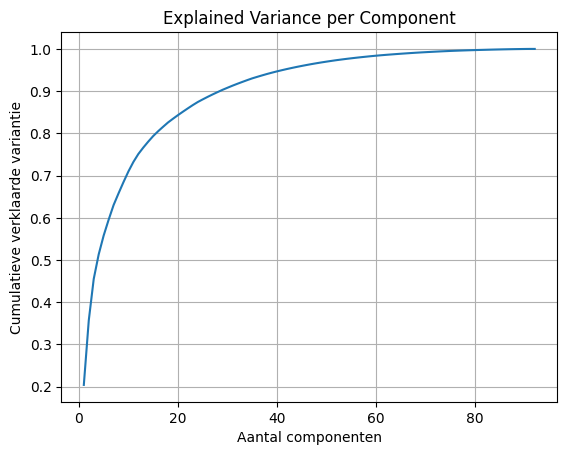

Aantal componenten dat meer dan 95% van de variantie verklaart: 42
Linear
Cross-Validation accuracy per fold: [0.47368421 0.63157895 0.61111111 0.83333333 0.5       ]
Gemiddelde Cross-Validation accuracy: 0.6099415204678362
RBF
Cross-Validation accuracy per fold: [0.42105263 0.63157895 0.55555556 0.66666667 0.5       ]
Gemiddelde Cross-Validation accuracy: 0.5549707602339181
Poly
Cross-Validation accuracy per fold: [0.47368421 0.68421053 0.5        0.61111111 0.61111111]
Gemiddelde Cross-Validation accuracy: 0.5760233918128655


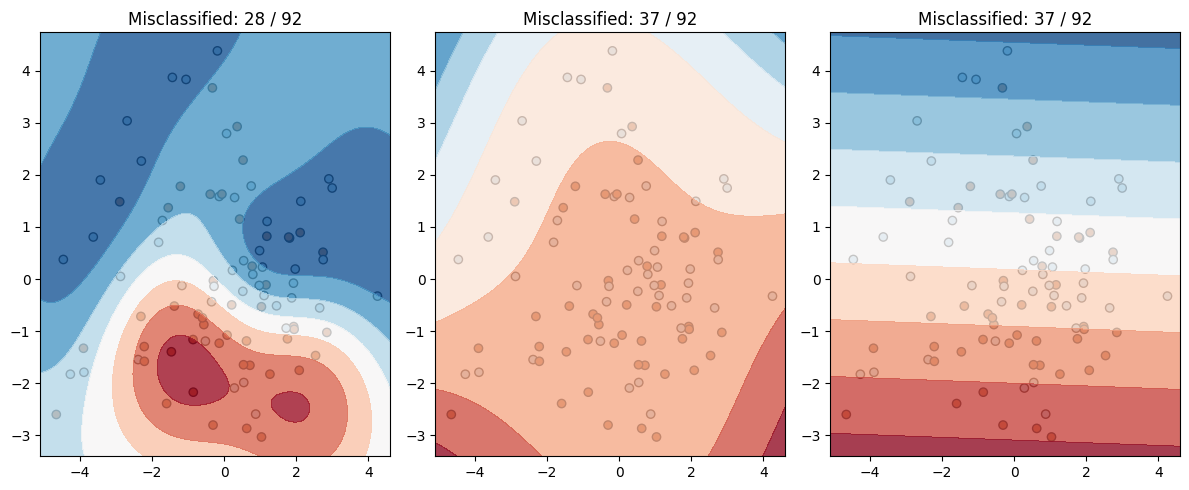

In [ ]:
# 5-voudige cross-validatie uitvoeren om SVM kernel uit te kiezen dat
# verder gebruikt gaat worden
from sklearn import decomposition  # Voor PCA
from sklearn.pipeline import make_pipeline  # Voor pipeline
from sklearn.svm import SVC, LinearSVC  # Voor Support Vector Machine
from sklearn.model_selection import cross_val_score, train_test_split
# Pas PCA toe
pca = decomposition.PCA()
X_pca = pca.fit_transform(X_train_scaled)

# Plot de cumulatieve verklaarde variantie
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Aantal componenten')
plt.ylabel('Cumulatieve verklaarde variantie')
plt.title('Explained Variance per Component')
plt.grid(True)
plt.show()
# Zoek het aantal componenten dat meer dan 95% van de variantie verklaart
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cumulative_variance >= 0.95) + 1  # +1 omdat index begint bij 0

print(f"Aantal componenten dat meer dan 95% van de variantie verklaart: {num_components}")
#PCA voor dimensie reductie
pca = decomposition.PCA(n_components=0.95)

# linear
svm = SVC(kernel='linear')
pipeline = make_pipeline(pca, svm)
scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=5)

print("Linear")
print("Cross-Validation accuracy per fold:", scores)
print("Gemiddelde Cross-Validation accuracy:", scores.mean())

#rbf
svm = SVC(kernel='rbf')
pipeline = make_pipeline(pca, svm)
scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=5)

print("RBF")
print("Cross-Validation accuracy per fold:", scores)
print("Gemiddelde Cross-Validation accuracy:", scores.mean())

#poly
svm = SVC(kernel='poly')
pipeline = make_pipeline(pca, svm)
scores = cross_val_score(pipeline, X_train_scaled, y_train, cv=5)

print("Poly")
print("Cross-Validation accuracy per fold:", scores)
print("Gemiddelde Cross-Validation accuracy:", scores.mean())


# PCA toepassen voor visualisatie
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

#Definieer en train SVM met linear kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_pca, y_train)

# Definieer en train SVM met RBF kernel
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_pca, y_train)

# Definieer en train SVM met Poly kernel
svm_poly = SVC(kernel='poly')
svm_poly.fit(X_pca, y_train)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot voor RBF kernel
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
colorplot(svm_rbf, axes[0], X_pca[:, 0], X_pca[:, 1])
y_pred = svm_rbf.predict(X_pca)
t = ("Misclassified: %d / %d" % ((y_train != y_pred).sum(), X_pca.shape[0]))
axes[0].set_title(t)

# Plot voor Poly kernel
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
colorplot(svm_poly, axes[1], X_pca[:, 0], X_pca[:, 1])
y_pred = svm_poly.predict(X_pca)
t = ("Misclassified: %d / %d" % ((y_train != y_pred).sum(), X_pca.shape[0]))
axes[1].set_title(t)

#plot voor linear kernel
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
colorplot(svm_linear, axes[2], X_pca[:, 0], X_pca[:, 1])
y_pred = svm_linear.predict(X_pca)
t = ("Misclassified: %d / %d" % ((y_train != y_pred).sum(), X_pca.shape[0]))
axes[2].set_title(t)

plt.tight_layout()

plt.show()


# Tuning hyperparameters

    param_svc__C param_svc__kernel  param_svc__gamma  param_svc__degree  \
1          0.010            linear               NaN                NaN   
2          0.100            linear               NaN                NaN   
4         10.000            linear               NaN                NaN   
29        10.000               rbf            0.0001                NaN   
79         1.000              poly               NaN                2.0   
75         1.000              poly               NaN                2.0   
24         1.000               rbf            0.0010                NaN   
0          0.001            linear               NaN                NaN   
67         0.100              poly               NaN                2.0   
30        10.000               rbf            0.0010                NaN   

    param_svc__coef0  mean_test_score  std_test_score  rank_test_score  
1                NaN         0.675439        0.146012                1  
2                NaN        

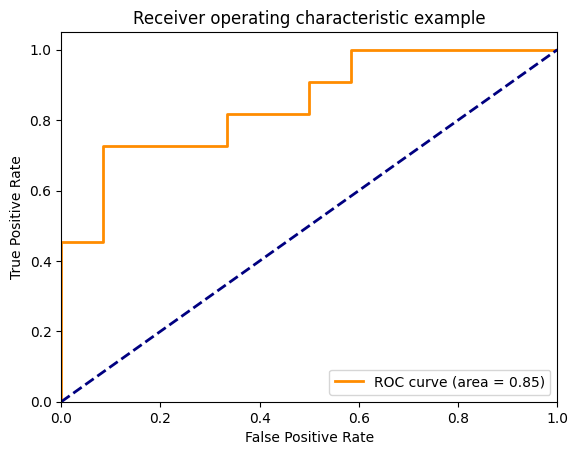

Accuracy op testset: 0.782608695652174


In [6]:
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score
import numpy as np
import pandas as pd
#data split
X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=42)
# scaling
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# dimensie reductie met pca
pca = decomposition.PCA(n_components=0.95)
#SVM selectie
svm = SVC()

pipeline = make_pipeline(pca, svm)

# Gescheiden parameter grids per kernel
param_grid = [
    {'svc__C': [0.001, 0.01, 0.1, 1, 10], 'svc__kernel': ['linear']},  # Linear kernel
    {'svc__C': [0.001, 0.01, 0.1, 1, 10], 'svc__kernel': ['rbf'], 'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},  # RBF kernel
    {'svc__C': [0.001, 0.01, 0.1, 1, 10], 'svc__kernel': ['poly'], 'svc__degree': [2, 3, 4, 5], 'svc__coef0': [0.0, 0.5, 1.0]}  # Polynomial kernel
]

# GridSearch instellen met cross-validation
clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
clf.fit(X_train_scaled, y_train)

# Maak een DataFrame van de resultaten
results_df = pd.DataFrame(clf.cv_results_)
# Selecteer relevante kolommen
results_df = results_df[['param_svc__C', 'param_svc__kernel', 'param_svc__gamma',
                         'param_svc__degree', 'param_svc__coef0',
                         'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values(by='rank_test_score')

# Toon de top 10 beste combinaties
print(results_df.head(10))

# Beste hyperparameters en score weergeven
print("Beste hyperparameters:", clf.best_params_)
print("Beste cross-validation score:", clf.best_score_)
y_score = clf.decision_function(X_test_scaled)
plot_roc_curve(y_score, y_test)
y_pred = clf.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy op testset:", test_accuracy)




## Principal component analysis

Run 1/100
Beste hyperparameters: {'svc__C': 0.1, 'svc__kernel': 'linear'}
Test accuracy voor deze run: 0.5652
Run 2/100
Beste hyperparameters: {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
Test accuracy voor deze run: 0.5217
Run 3/100
Beste hyperparameters: {'svc__C': 2, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy voor deze run: 0.7391
Run 4/100
Beste hyperparameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}
Test accuracy voor deze run: 0.6522
Run 5/100
Beste hyperparameters: {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
Test accuracy voor deze run: 0.7391
Run 6/100
Beste hyperparameters: {'svc__C': 4, 'svc__degree': 2, 'svc__kernel': 'poly'}
Test accuracy voor deze run: 0.3478
Run 7/100
Beste hyperparameters: {'svc__C': 4, 'svc__degree': 3, 'svc__kernel': 'poly'}
Test accuracy voor deze run: 0.6522
Run 8/100
Beste hyperparameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}
Test accuracy voor deze run: 0.6522
Run 9/100
Beste hyperparameters: {'svc

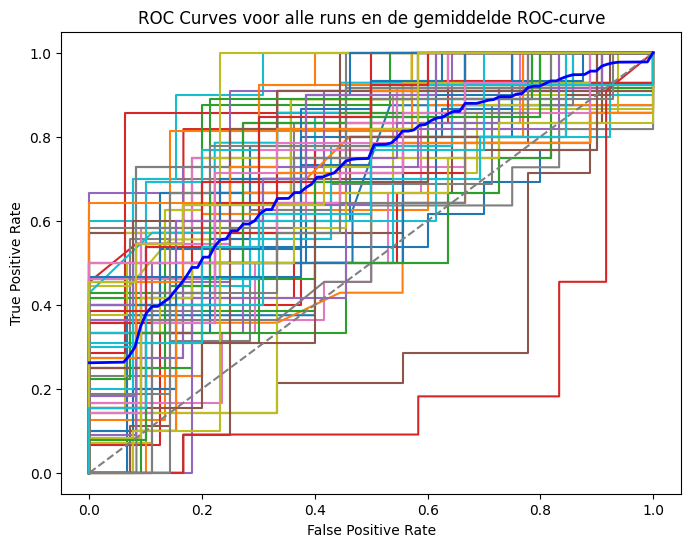

Gemiddelde AUC over alle runs: 0.7149


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc

# Zorg ervoor dat features en ground_truth numpy arrays zijn
features = np.array(features)  # Zet je DataFrame om naar een numpy array
ground_truth = np.array(ground_truth)  # Zet ground_truth om naar numpy array

# Hyperparameter grid
param_grid = [
    {'svc__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 10, 100, 1000], 'svc__kernel': ['linear']},
    {'svc__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 10, 100, 1000], 'svc__kernel': ['rbf'], 'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
    {'svc__C': [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 10, 100, 1000], 'svc__kernel': ['poly'], 'svc__degree': [2, 3, 4, 5]}
]

# Opslag voor accuracies en ROC-waarden
accuracies = []
roc_curves = []
mean_fpr = np.linspace(0, 1, 100)  # Genereer een vaste FPR voor de gemiddelde ROC-curve
mean_tpr = np.zeros_like(mean_fpr)  # Zet de gemiddelde TPR op 0

# 20 Random Splits
plt.figure(figsize=(8, 6))  # ROC-plot initialiseren
for run in range(100):  # 20 verschillende splits
    print(f"Run {run + 1}/100")

    # Split de data in training en test (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # PCA
    pca = decomposition.PCA(0.95)

    # SVM
    svm = SVC(probability=True)  # Probability=True nodig voor ROC

    # Pipeline
    # pipeline = make_pipeline(pca, svm)
    pipeline = make_pipeline(
    pca, svm)

    # GridSearch instellen
    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)

    # Beste model testen
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Beste hyperparameters: {clf.best_params_}")
    print(f"Test accuracy voor deze run: {accuracy:.4f}")

    # ROC berekenen
    y_score = clf.predict_proba(X_test_scaled)[:, 1]  # Positieve klasse kans
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, auc_score))

    # Interpoleer de TPR naar een vaste FPR om de gemiddelde ROC-curve te berekenen
    mean_tpr += np.interp(mean_fpr, fpr, tpr)

    # ROC-curve plotten voor deze run
    plt.plot(fpr, tpr, label=f"Run {run+1} (AUC = {auc_score:.2f})")

# Gemiddelde accuracy over alle runs
mean_accuracy = np.mean(accuracies)
print(f"\nGemiddelde test accuracy over 100 runs: {mean_accuracy:.4f}")

# Gemiddelde ROC-curve berekenen
mean_tpr /= 100  # Gemiddelde TPR over alle runs
mean_auc = auc(mean_fpr, mean_tpr)  # Gemiddelde AUC

# Plot de gemiddelde ROC-curve
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonaal (random model)
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves voor alle runs en de gemiddelde ROC-curve")
# plt.legend()
plt.show()

# Print de gemiddelde AUC
print(f"Gemiddelde AUC over alle runs: {mean_auc:.4f}")


In [ ]:
## Finding ID's with missing feature values
zero_value_feature = {}
for id in features.index:
    if (features.loc[id] == 0).any():
        zero_columns = features.columns[features.loc[id] == 0].tolist()  # Find columns where value is 0
        zero_value_feature[id] = zero_columns
    else:
        continue

## KNN


Run 1/50
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 8, 'selectkbest__k': 3}
Test accuracy voor deze run: 0.6087
Run 2/50
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 8, 'selectkbest__k': 3}
Test accuracy voor deze run: 0.7391
Run 3/50
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 8, 'selectkbest__k': 3}
Test accuracy voor deze run: 0.7391
Run 4/50
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 8, 'selectkbest__k': 3}
Test accuracy voor deze run: 0.7391
Run 5/50
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 8, 'selectkbest__k': 3}
Test accuracy voor deze run: 0.7826
Run 6/50
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 8, 'selectkbest__k': 3}
Test accuracy voor deze run: 0.6087
Run 7/50
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 8, 'selectkbest__k': 3}
Test accuracy voor deze run: 0.6522
Run 8/50
Beste hyperparameters: {'kneighborsclassifier__n_neighbors': 8, 'selectkbest__k':

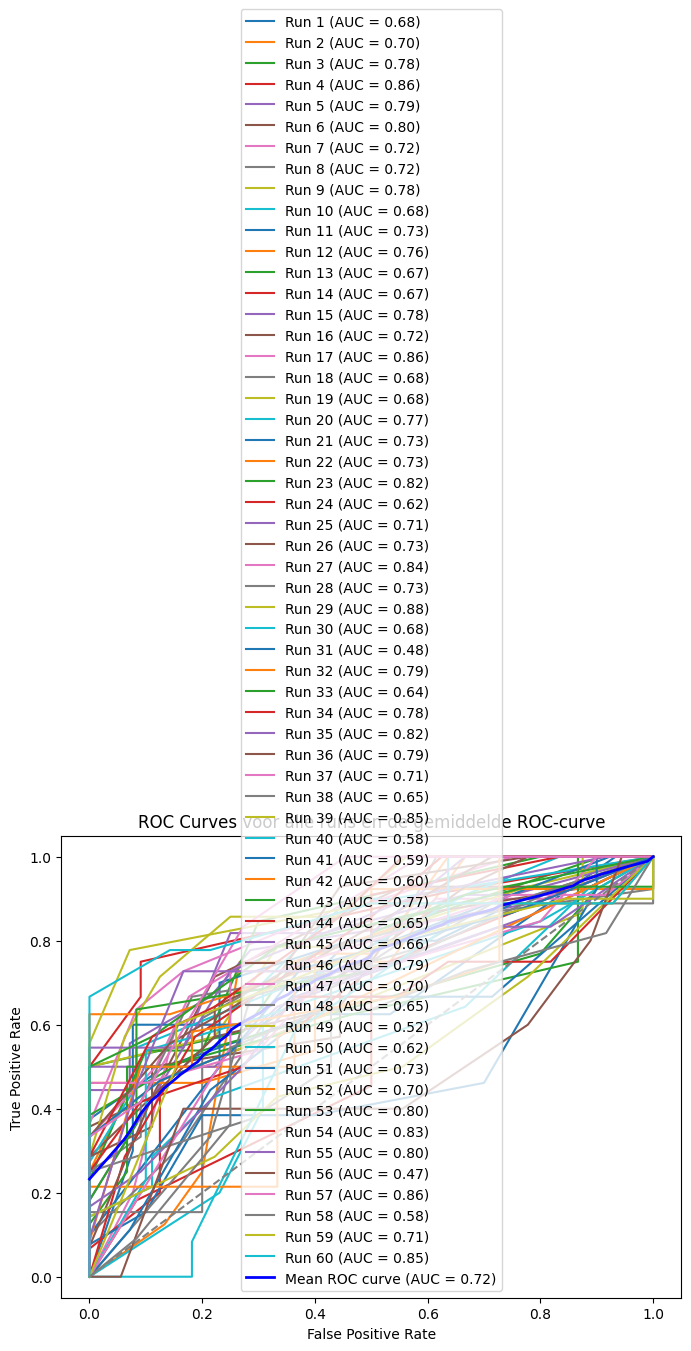

Gemiddelde AUC over alle runs: 0.7206


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2

# Zorg ervoor dat features en ground_truth numpy arrays zijn
features = np.array(features)  # Zet je DataFrame om naar een numpy array
ground_truth = np.array(ground_truth)  # Zet ground_truth om naar numpy array

# Opslag voor accuracies en ROC-waarden
accuracies = []
roc_curves = []
mean_fpr = np.linspace(0, 1, 100)  # Genereer een vaste FPR voor de gemiddelde ROC-curve
mean_tpr = np.zeros_like(mean_fpr)  # Zet de gemiddelde TPR op 0

# 50 Random Splits
plt.figure(figsize=(8, 6))  # ROC-plot initialiseren
for run in range(60):  # 50 verschillende splits
    print(f"Run {run + 1}/50")

    # Split de data in training en test (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

    # Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pipeline = make_pipeline(
    SelectKBest(score_func=mutual_info_classif),
    KNeighborsClassifier()
    )

    param_grid = {
        'selectkbest__k': [3],
        'kneighborsclassifier__n_neighbors': [8]
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)
    # Beste model testen
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Beste hyperparameters: {grid_search.best_params_}")
    print(f"Test accuracy voor deze run: {accuracy:.4f}")

    # ROC berekenen
    y_score = best_knn.predict_proba(X_test_scaled)[:, 1]  # Positieve klasse kans
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, auc_score))

    # Interpoleer de TPR naar een vaste FPR om de gemiddelde ROC-curve te berekenen
    mean_tpr += np.interp(mean_fpr, fpr, tpr)

    # ROC-curve plotten voor deze run
    plt.plot(fpr, tpr, label=f"Run {run+1} (AUC = {auc_score:.2f})")

# Gemiddelde accuracy over alle runs
mean_accuracy = np.mean(accuracies)
print(f"\nGemiddelde test accuracy over 50 runs: {mean_accuracy:.4f}")

# Gemiddelde ROC-curve berekenen
mean_tpr /= 60  # Gemiddelde TPR over alle runs
mean_auc = auc(mean_fpr, mean_tpr)  # Gemiddelde AUC

# Plot de gemiddelde ROC-curve
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonaal (random model)
plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves voor alle runs en de gemiddelde ROC-curve")
plt.legend()
plt.show()

# Print de gemiddelde AUC
print(f"Gemiddelde AUC over alle runs: {mean_auc:.4f}")



# Random forest

Run 1/100
Beste hyperparameters: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__min_impurity_decrease': 0.05, 'randomforestclassifier__n_estimators': 30}
Test accuracy voor deze run: 0.6087
Run 2/100
Beste hyperparameters: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__min_impurity_decrease': 0.01, 'randomforestclassifier__n_estimators': 60}
Test accuracy voor deze run: 0.5217
Run 3/100
Beste hyperparameters: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__min_impurity_decrease': 0.05, 'randomforestclassifier__n_estimators': 50}
Test accuracy voor deze run: 0.7391
Run 4/100
Beste hyperparameters: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__min_impurity_decrease': 0.05, 'randomforestclassifier__n_estimators': 10}
Test accuracy voor deze run: 0.6087
Run 5/100
Beste hyperparameters: {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__min_impurity_decrease': 0.05, 'randomforestclas

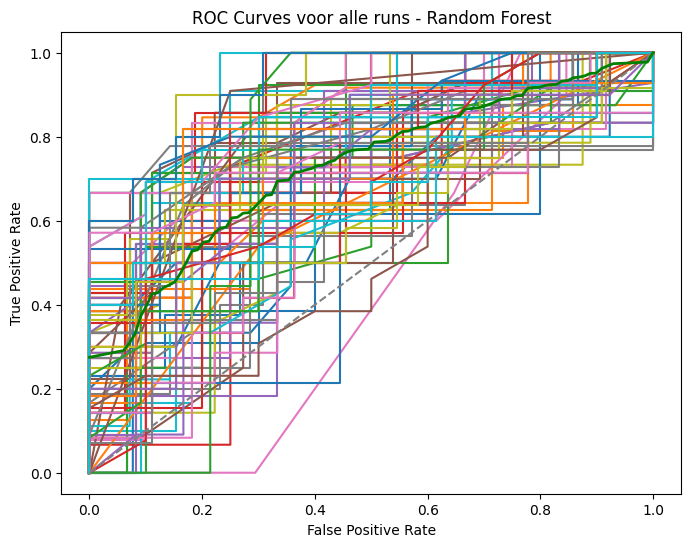

Gemiddelde AUC over alle runs: 0.7278


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import decomposition
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc

# Zorg ervoor dat features en ground_truth numpy arrays zijn
features = np.array(features)
ground_truth = np.array(ground_truth)

# Hyperparameter grid
param_grid = {
    'randomforestclassifier__n_estimators': [1, 10, 20, 30, 40, 50, 60],
    # 'randomforestclassifier__max_depth': [None, 10, 20, 30],
    # 'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_impurity_decrease': [0.0, 0.01, 0.05],
    'randomforestclassifier__bootstrap': [True, False]
}

# Opslag voor accuracies en ROC-waarden
accuracies = []
roc_curves = []
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

plt.figure(figsize=(8, 6))  # ROC plot

for run in range(100):
    print(f"Run {run + 1}/100")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

    # Scaling (optioneel bij RF, maar laten we het consistent houden met PCA)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Random Forest model
    rf = RandomForestClassifier()

    # Pipeline
    from sklearn.pipeline import make_pipeline
    pipeline = make_pipeline(rf)

    # GridSearch
    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)

    # Voorspelling
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Beste hyperparameters: {clf.best_params_}")
    print(f"Test accuracy voor deze run: {accuracy:.4f}")

    # ROC & AUC
    y_score = clf.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, auc_score))

    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    plt.plot(fpr, tpr, label=f"Run {run+1} (AUC = {auc_score:.2f})")

# Gemiddelde accuracy
mean_accuracy = np.mean(accuracies)
print(f"\nGemiddelde test accuracy over 100 runs: {mean_accuracy:.4f}")

# Gemiddelde ROC
mean_tpr /= 100
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.plot(mean_fpr, mean_tpr, color='green', lw=2, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves voor alle runs - Random Forest")
# plt.legend()
plt.show()

# Print de gemiddelde AUC
print(f"Gemiddelde AUC over alle runs: {mean_auc:.4f}")


Run 1/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.0, 'n_estimators': 50} | Accuracy: 0.4348
Run 2/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.0, 'n_estimators': 50} | Accuracy: 0.3913
Run 3/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.0, 'n_estimators': 50} | Accuracy: 0.6957
Run 4/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.01, 'n_estimators': 50} | Accuracy: 0.5217
Run 5/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.01, 'n_estimators': 50} | Accuracy: 0.6087
Run 6/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.0, 'n_estimators': 10} | Accuracy: 0.5217
Run 7/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.01, 'n_estimators': 50} | Accuracy: 0.7391
Run 8/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.0, 'n_estimators': 50} | Accuracy: 0.6957
Run 9/10
RF params: {'bootstrap': True, 'min_impurity_decrease': 0.0, 'n_estimators': 50} | Accuracy: 0.5652
Run 10/10
RF par

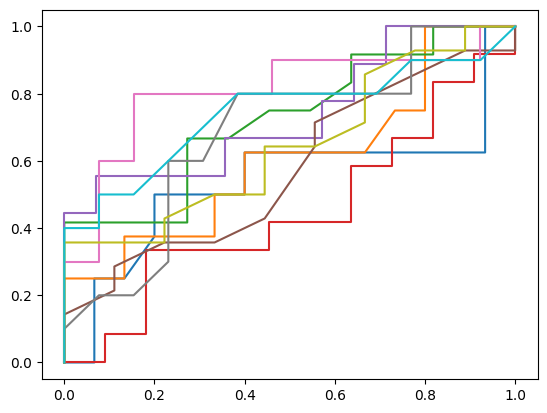

In [22]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Zorg ervoor dat features en ground_truth numpy arrays zijn
features = np.array(features)
ground_truth = np.array(ground_truth)

# Opslag voor accuracies en ROC-waarden
accuracies = []
roc_curves = []
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

# Hyperparameter grid voor GridSearchCV
rf_params = {
    'randomforestclassifier__n_estimators': [10, 50, 100],
    'randomforestclassifier__min_impurity_decrease': [0.0, 0.01],
    'randomforestclassifier__bootstrap': [True, False]
}

knn_params = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7]
    # 'kneighborsclassifier__weights': ['uniform', 'distance']
}

plt.figure(figsize=(8, 6))  # ROC plot

for run in range(10):  # Aantal runs
    print(f"Run {run + 1}/10")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(features, ground_truth, test_size=0.2, random_state=run)

    # Scaling (zonder PCA)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Classifiers
    rf = RandomForestClassifier()
    knn = KNeighborsClassifier()

    # Ensemble via VotingClassifier (soft voting)
    voting_clf = VotingClassifier(estimators=[
        ('rf', rf),
        ('knn', knn)
    ], voting='soft')  # Gebruik soft voting voor probabilistische voorspellingen

    # GridSearchCV voor het ensemble
    param_grid = {
        'rf': rf_params,
        'knn': knn_params
    }

    # Maak een pipeline met het VotingClassifier ensemble
    select = SelectKBest(score_func=mutual_info_classif)
    pipeline = make_pipeline(select, voting_clf)

    # GridSearch instellen
    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)

    # Voorspelling
    y_pred = clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Beste hyperparameters: {clf.best_params_}")
    print(f"Test accuracy voor deze run: {accuracy:.4f}")

    # ROC & AUC
    y_score = clf.predict_proba(X_test_scaled)[:, 1]  # Gebruik de probabiliteiten van de positieve klasse
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, auc_score))

    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    plt.plot(fpr, tpr, label=f"Run {run+1} (AUC = {auc_score:.2f})")

# Gemiddelde accuracy
mean_accuracy = np.mean(accuracies)
print(f"\nGemiddelde test accuracy over 10 runs: {mean_accuracy:.4f}")

# Gemiddelde ROC
mean_tpr /= 10
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.plot(mean_fpr, mean_tpr, color='green', lw=2, label=f'Mean ROC curve (AUC = {mean_auc:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves voor alle runs - Random Forest + KNN (Voting)")
plt.legend()
plt.show()

# Print de gemiddelde AUC
print(f"Gemiddelde AUC over alle runs: {mean_auc:.4f}")
